Slop Forensics Toolkit - Colab Runner

Created by Sam Paech

Code repository: https://github.com/sam-paech/slop-forensics

This notebook downloads the Slop Forensics toolkit, installs dependencies,
and runs through the main workflow steps as described in the README.

**Requires:**
- An OpenAI-compatible base url & API Key (e.g., from OpenRouter)
- Several dependencies (installed in the first cell of the notebook)

In [16]:
# @title 1. Setup Environment and Dependencies
# @markdown Clone the repository, install Python requirements, system dependencies (PHYLIP), and NLTK data.

import os
import sys
import subprocess
import nltk
from google.colab import userdata # For secrets

# Reset to a known location first
if 'COLAB_GPU' in os.environ:  # Check if we're in Colab
    # Reset to Colab root directory
    os.chdir('/content')
else:
    # For local environments, try to find the root of the repository
    current_dir = os.getcwd()
    # Go up until we're out of any nested slop-forensics directories
    while 'slop-forensics' in current_dir and current_dir != os.path.dirname(current_dir):
        current_dir = os.path.dirname(current_dir)
    os.chdir(current_dir)

print(f"Reset to clean directory: {os.getcwd()}")

# --- Configuration ---
GIT_REPO_URL = "https://github.com/sam-paech/slop-forensics.git"
REPO_DIR = "slop-forensics"
# --- End Configuration ---

print("Updating package list...")
!sudo apt-get update -qq

# Check if the repository already exists
if not os.path.exists(REPO_DIR):
    print(f"\nCloning the repository to {REPO_DIR}...")
    !git clone {GIT_REPO_URL}
else:
    print(f"\nRepository directory '{REPO_DIR}' already exists. Skipping clone.")
    # Optionally pull latest changes if it's a git repository
    if os.path.exists(os.path.join(REPO_DIR, ".git")):
        print("Pulling latest changes...")
        !cd {REPO_DIR} && git pull

# Add project root to Python path for imports within scripts
project_root = os.path.abspath(os.getcwd())
sys.path.insert(0, project_root)
print(f"Added {project_root} to sys.path")

# Change directory into the repository (only if not already in it)
current_dir = os.getcwd()
target_dir = os.path.join(project_root, REPO_DIR)

if current_dir != target_dir:
    print(f"\nChanging directory to {REPO_DIR}...")
    os.chdir(target_dir)
    print(f"Current working directory: {os.getcwd()}")
else:
    print(f"\nAlready in the correct directory: {current_dir}")

print("\nInstalling Python dependencies from requirements.txt...")
# Using -q for quieter output, remove if you want to see all details
!pip install -q -r requirements.txt

print("\nInstalling system dependencies (PHYLIP)...")
# Using -qq for quieter output, remove if you want to see all details
# Using -y to automatically confirm installation
!sudo apt-get install -y -qq phylip

# Verify PHYLIP installation (optional)
print("\nVerifying PHYLIP installation (checking for 'pars')...")
try:
    result = subprocess.run(['which', 'pars'], capture_output=True, text=True, check=True)
    print(f"PHYLIP 'pars' found at: {result.stdout.strip()}")
    PHYLIP_INSTALLED = True
    # PHYLIP is usually installed in /usr/local/bin, which should be in PATH
    PHYLIP_PATH = "/usr/local/bin"
except subprocess.CalledProcessError:
    print("WARN: PHYLIP 'pars' command not found in PATH after installation.")
    print("Phylogenetic tree generation using parsimony might fail.")
    print("The script might fall back to hierarchical clustering.")
    PHYLIP_INSTALLED = False
    PHYLIP_PATH = "/usr/local/bin" # Let the script try the default PATH

print("\nDownloading required NLTK data...")
try:
    nltk.download('punkt', quiet=False)
    nltk.download('punkt_tab', quiet=False)
    nltk.download('stopwords', quiet=False)
    nltk.download('cmudict', quiet=False)
    print("NLTK data downloaded successfully.")
except Exception as e:
    print(f"Error downloading NLTK data: {e}")
    print("Some analysis features might be limited.")

print("\nSetup complete.")

Reset to clean directory: /content
Updating package list...
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)

Repository directory 'slop-forensics' already exists. Skipping clone.
Pulling latest changes...
Already up to date.
Added /content to sys.path

Changing directory to slop-forensics...
Current working directory: /content/slop-forensics

Installing Python dependencies from requirements.txt...

Installing system dependencies (PHYLIP)...

Verifying PHYLIP installation (checking for 'pars')...
WARN: PHYLIP 'pars' command not found in PATH after installation.
Phylogenetic tree generation using parsimony might fail.
The script might fall back to hierarchical clustering.

NLTK data downloaded successfully.

Setup complete.


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package cmudict to /root/nltk_data...
[nltk_data]   Package cmudict is already up-to-date!


In [ ]:
# @title 2. Configure API Key and Environment
# @markdown Create the `.env` file using Colab Secrets.

# --- Configuration ---
# Models to run the generation step for (comma-separated string)
# Using a small set for demonstration purposes. Add more as needed.
# Ensure these models are available via your API provider (e.g., OpenRouter)
MODELS_TO_RUN = "x-ai/grok-3-mini-beta,meta-llama/llama-4-maverick,meta-llama/llama-4-scout,google/gemma-3-4b-it"

# Number of records to generate per model (use a small number for testing)
NUM_GENERATIONS = 100 # Default in repo is 1000, use 5-10 for quick test

# --- End Configuration ---


# --- API Config ---
# This code assumes you have an OpenAI compatible API ready to go.
# You could use openrouter, or vllm/llama.cpp etc for local models.
base_url="https://openrouter.ai/api/v1"
api_key="YOUR_API_KEY"

# --- Create .env file ---
env_content = f"""
# OpenAI Compatible API Key (or other LLM provider)
OPENAI_API_KEY=\"{api_key}\"
OPENAI_BASE_URL=\"{base_url}\"
"""
try:
    with open(".env", "w") as f:
        f.write(env_content.strip())
    print("\nSuccessfully created .env file:")
    !cat .env
except IOError as e:
    print(f"\nError writing .env file: {e}")

# --- Set Environment Variable for ETE3 ---
# ETE3 uses Qt for visualization, which can cause issues in headless environments.
# The phylogeny script already does this, but setting it here ensures it's done early.
os.environ["QT_QPA_PLATFORM"] = "offscreen"
print("\nSet QT_QPA_PLATFORM=offscreen for ETE3.")

print("\nConfiguration complete.")

In [19]:
# @title 3. Run Workflow Step 1: Generate Dataset
# @markdown Use `generate_dataset.py` to prompt the specified LLMs.
# @markdown **Note:** This step calls the LLM API and may incur costs.
# @markdown It can also take time depending on the number of generations and API responsiveness.

print(f"Starting dataset generation for {NUM_GENERATIONS} records per model...")
print(f"Models: {MODELS_TO_RUN}")

# Construct the command
generate_command = f"""
python3 scripts/generate_dataset.py \
  --model-ids \"{MODELS_TO_RUN}\" \
  --generate-n {NUM_GENERATIONS}
"""

# Run the command
print("\nExecuting command:")
print(generate_command)
!{generate_command}

print("\nDataset generation script finished.")
print("Check the 'results/datasets/' directory for output .jsonl files.")
!ls -l results/datasets/

Starting dataset generation for 100 records per model...
Models: x-ai/grok-3-mini-beta,meta-llama/llama-4-maverick,meta-llama/llama-4-scout,google/gemma-3-4b-it

Executing command:

python3 scripts/generate_dataset.py   --model-ids "x-ai/grok-3-mini-beta,meta-llama/llama-4-maverick,meta-llama/llama-4-scout,google/gemma-3-4b-it"   --generate-n 100

2025-04-10 09:19:29,565 - INFO - generate_dataset - Starting dataset generation for models: x-ai/grok-3-mini-beta, meta-llama/llama-4-maverick, meta-llama/llama-4-scout, google/gemma-3-4b-it
2025-04-10 09:19:29,565 - INFO - generate_dataset - Output directory: /content/slop-forensics/results/datasets
2025-04-10 09:19:29,565 - INFO - generate_dataset - Target records per model: 100
2025-04-10 09:19:29,565 - INFO - dataset_generator - Starting generation process for model: x-ai/grok-3-mini-beta
2025-04-10 09:19:29,565 - INFO - dataset_generator - Loading dataset: Nitral-AI/Reddit-SFW-Writing_Prompts_ShareGPT (Source: Nitral-AI)
2025-04-10 09:19

In [20]:
# @title 4. Run Workflow Step 2: Analyze Outputs & Profile Slop
# @markdown Use `slop_profile.py` to analyze the generated datasets for metrics and features.

# Print the paths where NLTK is looking for data
print("NLTK data paths:", nltk.data.path)

# Verify punkt is accessible
try:
    tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
    print("Successfully loaded punkt tokenizer")
except Exception as e:
    print(f"Error loading punkt tokenizer: {e}")

print("Starting analysis of generated datasets...")

# Run the command (using defaults)
analyze_command = "python3 scripts/slop_profile.py"

print("\nExecuting command:")
print(analyze_command)
!{analyze_command}

print("\nAnalysis script finished.")
print("Check 'results/analysis/' for per-model JSON files.")
print("Check 'results/slop_profile_results.json' for the combined metrics.")
print("\nCombined metrics file location:")
!ls -l results/slop_profile_results.json
print("\nIndividual analysis file locations:")
!ls -l results/analysis/

NLTK data paths: ['/root/nltk_data', '/usr/nltk_data', '/usr/share/nltk_data', '/usr/lib/nltk_data', '/usr/share/nltk_data', '/usr/local/share/nltk_data', '/usr/lib/nltk_data', '/usr/local/lib/nltk_data']
Successfully loaded punkt tokenizer
Starting analysis of generated datasets...

Executing command:
python3 scripts/slop_profile.py
2025-04-10 09:23:28,408 - INFO - slop_profile - Starting analysis of datasets in: /content/slop-forensics/results/datasets
2025-04-10 09:23:28,408 - INFO - slop_profile - Analysis output directory: /content/slop-forensics/results/analysis
2025-04-10 09:23:28,408 - INFO - slop_profile - Combined metrics output file: /content/slop-forensics/results/slop_profile_results.json
2025-04-10 09:23:28,408 - INFO - slop_profile - Max items per model: 10000
2025-04-10 09:23:28,409 - INFO - slop_profile - Will log top 5 patterns per model
2025-04-10 09:23:28,409 - INFO - slop_profile - Found 4 dataset files to analyze.
2025-04-10 09:23:28,409 - WARNING - utils - File n

In [21]:
# @title 5. Run Workflow Step 3: Create Slop Lists
# @markdown Use `create_slop_lists.py` to aggregate findings and build canonical slop lists.

print("Starting slop list creation...")

# Run the command (using defaults)
slop_list_command = "python3 scripts/create_slop_lists.py"

print("\nExecuting command:")
print(slop_list_command)
!{slop_list_command}

print("\nSlop list creation script finished.")
print("Check 'results/slop_lists/' for the generated lists:")
!ls -l results/slop_lists/

Starting slop list creation...

Executing command:
python3 scripts/create_slop_lists.py
2025-04-10 09:23:59,477 - INFO - create_slop_lists - Starting slop list creation from analysis files in: /content/slop-forensics/results/analysis
2025-04-10 09:23:59,477 - INFO - create_slop_lists - Output directory: /content/slop-forensics/results/slop_lists
2025-04-10 09:23:59,477 - INFO - slop_lists - Starting combined slop list generation...
2025-04-10 09:23:59,477 - INFO - slop_lists - Found 4 analysis files. Loading data...
Loading analysis files: 100% 4/4 [00:00<00:00, 147.97it/s]
2025-04-10 09:23:59,506 - INFO - slop_lists - Processing combined text data from 4 models...
2025-04-10 09:23:59,506 - INFO - slop_lists - Counting combined words...
Counting words: 100% 400/400 [00:00<00:00, 1103.64it/s]
2025-04-10 09:23:59,869 - INFO - slop_lists - Filtering combined counts...
2025-04-10 09:23:59,896 - INFO - slop_lists - Analyzing combined word rarity...
2025-04-10 09:24:00,273 - INFO - slop_list

In [22]:
# @title 6. Run Workflow Step 4: Generate Phylogenetic Trees
# @markdown Use `generate_phylo_trees.py` to cluster models based on slop profiles.
# @markdown **Note:** This step requires PHYLIP to be installed correctly for parsimony. If PHYLIP fails, it should fall back to hierarchical clustering.

print("Starting phylogenetic tree generation...")

# Run the command (using defaults)
phylo_command = "python3 scripts/generate_phylo_trees.py"

print("\nExecuting command:")
print(phylo_command)
!{phylo_command}

print("\nPhylogenetic tree generation script finished.")
print("Check 'results/phylogeny/' for tree files (Newick, Nexus) and charts:")
!ls -lR results/phylogeny/

Starting phylogenetic tree generation...

Executing command:
python3 scripts/generate_phylo_trees.py
2025-04-10 09:24:14,463 - INFO - generate_phylo_trees - Starting phylogenetic tree generation using data from: /content/slop-forensics/results/slop_profile_results.json
2025-04-10 09:24:14,463 - INFO - generate_phylo_trees - Output directory: /content/slop-forensics/results/phylogeny
2025-04-10 09:24:14,463 - INFO - generate_phylo_trees - Top N features per model: 1500
2025-04-10 09:24:14,464 - INFO - phylogeny - Starting phylogenetic tree generation...
2025-04-10 09:24:14,464 - INFO - phylogeny - Loading combined metrics data from: /content/slop-forensics/results/slop_profile_results.json
2025-04-10 09:24:14,477 - INFO - phylogeny - Extracting features (top words/ngrams) for tree building...
2025-04-10 09:24:14,479 - INFO - phylogeny - Attempting parsimony tree construction using PHYLIP...
2025-04-10 09:24:14,480 - INFO - phylogeny - Parsimony analysis: 4 models, 2565 features.
2025-04

--- Exploring Results ---

Looking for tree charts in: results/phylogeny/charts
Displaying chart: results/phylogeny/charts/meta-llama__llama-4-maverick__parsimony_rectangular.png


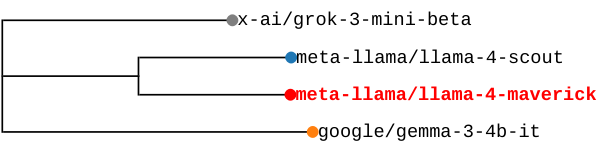


Loading word slop list from: results/slop_lists/slop_list.json
Top 15 words from results/slop_lists/slop_list.json:
- aback
- abernathy
- absently
- absentmindedly
- absurdities
- absurdity
- abuzz
- accusatory
- accustomed
- ache
- ached
- acrid
- adolescens
- adolescentus
- aelina

Loading phrase slop list from: results/slop_lists/slop_list_phrases.jsonl
Top 15 phrases from results/slop_lists/slop_list_phrases.jsonl:
- "took a deep breath" (freq: 84)
- "couldn't shake the feeling" (freq: 70)
- "felt a shiver run" (freq: 53)
- "voice barely above a whisper" (freq: 49)
- "shiver run down my spine" (freq: 40)
- "couldn't help but wonder" (freq: 39)
- "said, his voice low" (freq: 36)
- "couldn't help but feel" (freq: 35)
- "room fell silent" (freq: 26)
- "voice barely a whisper" (freq: 26)
- "rain continued to fall" (freq: 26)
- "couldn't help but think" (freq: 23)
- "words hung in the air" (freq: 21)
- "heart skipped a beat" (freq: 18)
- "smile playing on his lips" (freq: 18)

--- End 

In [ ]:
# @title 7. Explore Results (Optional)
# @markdown Display some of the generated results.

import json
from IPython.display import Image, display
import glob
import os # Ensure os is imported

print("--- Exploring Results ---")

# --- Display a generated tree chart ---
chart_dir = "results/phylogeny/charts"
print(f"\nLooking for tree charts in: {chart_dir}")
png_files = glob.glob(os.path.join(chart_dir, "*.png"))

if png_files:
    # Display the first circular PNG found
    display_file = None
    for f in png_files:
        if "circular" in f.lower():
             display_file = f
             break
    if not display_file: # Fallback to first PNG if no circular found
        display_file = png_files[0]

    print(f"Displaying chart: {display_file}")
    try:
        display(Image(filename=display_file, width=600))
    except Exception as e:
        print(f"Error displaying image {display_file}: {e}")
else:
    print("No .png charts found in the charts directory.")
    # Check if PHYLIP_INSTALLED was set earlier (requires running cell 1)
    if 'PHYLIP_INSTALLED' in locals() and not PHYLIP_INSTALLED:
        print("This might be because PHYLIP was not found or failed.")

# --- Display the first few items from the word slop list ---
slop_list_file = "results/slop_lists/slop_list.json"
print(f"\nLoading word slop list from: {slop_list_file}")

try:
    with open(slop_list_file, 'r') as f:
        slop_data = json.load(f)
    print(f"Top 15 words from {slop_list_file}:")
    # Data is list of lists, e.g., [["word1"], ["word2"]]
    for item in slop_data[:15]:
        print(f"- {item[0]}")
except FileNotFoundError:
    print(f"File not found: {slop_list_file}")
except (json.JSONDecodeError, IndexError, TypeError) as e:
    print(f"Error reading or parsing {slop_list_file}: {e}")


# --- Display the first few items from the phrase slop list ---
phrase_list_file = "results/slop_lists/slop_list_phrases.jsonl"
print(f"\nLoading phrase slop list from: {phrase_list_file}")

try:
    print(f"Top 15 phrases from {phrase_list_file}:")
    count = 0
    with open(phrase_list_file, 'r') as f:
        for line in f:
            if count >= 15:
                break
            try:
                # Data is JSONL: [phrase, frequency] per line
                phrase_data = json.loads(line)
                print(f"- \"{phrase_data[0]}\" (freq: {phrase_data[1]})")
                count += 1
            except (json.JSONDecodeError, IndexError, TypeError) as e:
                print(f"  Skipping invalid line: {line.strip()} ({e})")

except FileNotFoundError:
    print(f"File not found: {phrase_list_file}")
except Exception as e:
    print(f"Error reading {phrase_list_file}: {e}")


print("\n--- End Exploration ---")